# Uygulama 
Bu bölümde "titanic" veri setini gördüğümüz bütün konuları kapsayacak şekilde uçtan uca ele alacağız.

In [1]:
# Kütüphanelerimizi import edelim;

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
!pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [2]:
# Veri setini getirelim;
def load():
    data = pd.read_csv("datasets/titanic.csv")
    return data


In [3]:
# Veri setini df' e atayalım ve inceleyelim;
df = load()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Veri setini inceleyelim;
df.shape
# 12 değişken 891 veri olduğunu görüyoruz. 

(891, 12)

In [5]:
# Tüm değişkenlerin isimlerini tek bir formata getirmek adına, büyük harfe dönüştürelim;
df.columns = [col.upper() for col in df.columns]
df.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 1. Feature Engineering (Değişken Mühendisliği)

In [6]:
# Cabin bool
df["NEW_CABIN_BOOL"] = df["CABIN"].notnull().astype('int')
# Name count
df["NEW_NAME_COUNT"] = df["NAME"].str.len()
# name word count
df["NEW_NAME_WORD_COUNT"] = df["NAME"].apply(lambda x: len(str(x).split(" ")))
# name dr
df["NEW_NAME_DR"] = df["NAME"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))
# name title
df['NEW_TITLE'] = df.NAME.str.extract(' ([A-Za-z]+)\.', expand=False)
# family size
df["NEW_FAMILY_SIZE"] = df["SIBSP"] + df["PARCH"] + 1
# age_pclass
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]
# is alone
df.loc[((df['SIBSP'] + df['PARCH']) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df['SIBSP'] + df['PARCH']) == 0), "NEW_IS_ALONE"] = "YES"
# age level
df.loc[(df['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior'
# sex x age
df.loc[(df['SEX'] == 'male') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniorfemale'

df.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,...,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,23,4,0,Mr,2,66.0,NO,mature,maturemale
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,51,7,0,Mrs,2,38.0,NO,mature,maturefemale
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,22,3,0,Miss,1,78.0,YES,mature,maturefemale
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,44,7,0,Mrs,2,35.0,NO,mature,maturefemale
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,24,4,0,Mr,1,105.0,YES,mature,maturemale


In [7]:
# Önceden yazmış olduğumuz fonksiyonları tanımlayalım;

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


In [8]:
# Değişkenleri sınıflandırıyoruz;
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 22
cat_cols: 14
num_cols: 5
cat_but_car: 3
num_but_cat: 8


In [9]:
print("cat cols =", cat_cols)
print("num cols =",num_cols)
print("cat but car cols =",cat_but_car)

cat cols = ['SEX', 'EMBARKED', 'NEW_TITLE', 'NEW_IS_ALONE', 'NEW_AGE_CAT', 'NEW_SEX_CAT', 'SURVIVED', 'PCLASS', 'SIBSP', 'PARCH', 'NEW_CABIN_BOOL', 'NEW_NAME_WORD_COUNT', 'NEW_NAME_DR', 'NEW_FAMILY_SIZE']
num cols = ['PASSENGERID', 'AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']
cat but car cols = ['NAME', 'TICKET', 'CABIN']


In [10]:
# PASSENGERID bir numerik değişken olsa da index içerdiği için bunu çıkarmak istiyoruz; 

num_cols = [col for col in num_cols if "PASSENGERID" not in col]

### 2. Outliers (Aykırı Değerler)

In [11]:
# Önceki kısımlardan bir fonksiyon daha çağıralım;

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [12]:
for col in num_cols:
    print(col, check_outlier(df, col))

AGE True
FARE True
NEW_NAME_COUNT True
NEW_AGE_PCLASS True


In [13]:
# Önceki çalışmalardan bir fonksiyon daha çağırıyoruz;

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [14]:
# Yukarıdaki aykırı değerlerimizi baskılayalım;

for col in num_cols:
    replace_with_thresholds(df, col)

In [15]:
# Aykırı değer kalmış mı kontrol edelim;

for col in num_cols:
    print(col, check_outlier(df, col))

AGE False
FARE False
NEW_NAME_COUNT False
NEW_AGE_PCLASS False


### 3. Missing Values (Eksik Değerler)

In [16]:
# missing value notebook'undan bir fonksiyon çağıralım;

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [17]:
missing_values_table(df)

# kabin değişkeni için yeni bir değişken oluşturduk bu sebeple veri setimizden drop edebiliriz.
# Yaş değişkenindeki eksik değerlerden dolayı diğer veriler de eksik değer barındırıyor.

                n_miss  ratio
CABIN              687  77.10
AGE                177  19.87
NEW_AGE_PCLASS     177  19.87
NEW_AGE_CAT        177  19.87
NEW_SEX_CAT        177  19.87
EMBARKED             2   0.22


In [18]:
# cabin değişkenini veri setinden drop edelim;
#inplace ile kalıcı bir hale getirelim.
df.drop("CABIN", inplace=True, axis=1)

In [19]:
# Veri setindeki istemediğimiz diğer değişkenleri de drop edelim;

remove_cols = ["TICKET", "NAME"]
df.drop(remove_cols, inplace=True, axis=1)

In [20]:
df.head()

,PASSENGERID,SURVIVED,PCLASS,SEX,AGE,SIBSP,PARCH,FARE,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,male,22.0,1,0,7.2500,S,0,23,4,0,Mr,2,66.0,NO,mature,maturemale
1,2,1,1,female,38.0,1,0,65.6344,C,1,45,7,0,Mrs,2,38.0,NO,mature,maturefemale
2,3,1,3,female,26.0,0,0,7.9250,S,0,22,3,0,Miss,1,78.0,YES,mature,maturefemale
3,4,1,1,female,35.0,1,0,53.1000,S,1,44,7,0,Mrs,2,35.0,NO,mature,maturefemale
4,5,0,3,male,35.0,0,0,8.0500,S,0,24,4,0,Mr,1,105.0,YES,mature,maturemale


In [21]:
df["AGE"] = df["AGE"].fillna(df.groupby("NEW_TITLE")["AGE"].transform("median"))

# "AGE" değişkenindeki eksik değerleri "NEW_TITLE"la göre "groupby"a alıyoruz ve bu verilerin medyanına göre dolduruyoruz.

In [22]:
df.isnull().sum()

PASSENGERID              0
SURVIVED                 0
PCLASS                   0
SEX                      0
AGE                      0
SIBSP                    0
PARCH                    0
FARE                     0
EMBARKED                 2
NEW_CABIN_BOOL           0
NEW_NAME_COUNT           0
NEW_NAME_WORD_COUNT      0
NEW_NAME_DR              0
NEW_TITLE                0
NEW_FAMILY_SIZE          0
NEW_AGE_PCLASS         177
NEW_IS_ALONE             0
NEW_AGE_CAT            177
NEW_SEX_CAT            177
dtype: int64

In [23]:
# Bu yaş değişkeni üzerinden oluşturulan diğer değişkenleri yeniden oluşturmamız lazım;
# Burada görüyoruz ki feature engineering ile veri ön işleme birbirinden çok etkilenen süreçlerdir.

df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]

df.loc[(df['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior'

df.loc[(df['SEX'] == 'male') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniorfemale'

In [24]:
df.head()

,PASSENGERID,SURVIVED,PCLASS,SEX,AGE,SIBSP,PARCH,FARE,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,male,22.0,1,0,7.2500,S,0,23,4,0,Mr,2,66.0,NO,mature,maturemale
1,2,1,1,female,38.0,1,0,65.6344,C,1,45,7,0,Mrs,2,38.0,NO,mature,maturefemale
2,3,1,3,female,26.0,0,0,7.9250,S,0,22,3,0,Miss,1,78.0,YES,mature,maturefemale
3,4,1,1,female,35.0,1,0,53.1000,S,1,44,7,0,Mrs,2,35.0,NO,mature,maturefemale
4,5,0,3,male,35.0,0,0,8.0500,S,0,24,4,0,Mr,1,105.0,YES,mature,maturemale


In [25]:
# Kontrolümüzü edelim;

missing_values_table(df)

# Sadece embarked kaldı.

          n_miss  ratio
EMBARKED       2   0.22


In [26]:
# Embarked'ı da sistematik bir şekilde halledelim;

df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0)

In [27]:
missing_values_table(df)

# Eksik değerleri de halettik.

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


### 4. Label Encoding

In [28]:
# iki sınıflı kategorik değişkenleri bir seçelim;

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

binary_cols

['SEX', 'NEW_IS_ALONE']

In [29]:
df['NEW_IS_ALONE']

0       NO
1       NO
2      YES
3       NO
4      YES
      ... 
886    YES
887    YES
888     NO
889    YES
890    YES
Name: NEW_IS_ALONE, Length: 891, dtype: object

In [30]:
# Önceki çalışamlarımızdan bir fonksiyon çağıralım;

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [31]:
for col in binary_cols:
    df = label_encoder(df, col)

### 5. Rare Encoding

In [32]:
# Önceki bölümlerden fonksiyonlarımızı çağıralım;

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")


def rare_encoder(dataframe, rare_perc):

    # Üzerinde değişiklik yapılacağından dolayı dataframe'mimizin bir kopyasını alalım.
    temp_df = dataframe.copy()

    # rare_columns listesi tanımlayalım ve yakalayacağımız rare değişkenleri bu listede tutalım.
    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'    # değişkenin tipi object (kategorik) ise ve ...
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]
                    # ... veri içerisinde görülme sıklığı belirlenen "rare_perc" oranından küçük grup barındıran değişkenlerin seçilme işlemi
                    # Yukarıda ".any()" metodu da bulunmaktadır, içinde var ise listeye almasını söylüyoruz.


    for var in rare_columns:    # içerisinde görülme sıklığı %1'in altıda grup barındıran rare column'larda gez,
        tmp = temp_df[var].value_counts() / len(temp_df) # Bu değişken/sütunlar içerisindeki grupların yüzdelerini hesapla,
        rare_labels = tmp[tmp < rare_perc].index    # Bu hesaplanan yüzdeler "rare_perc"ten küçük ise bunların indeksini al,
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var]) # indeksi alınan yerdeki değişkene rare yaz diyoruz.

    return temp_df

In [33]:
rare_analyser(df, "SURVIVED", cat_cols)

SEX : 2
   COUNT     RATIO  TARGET_MEAN
0    314  0.352413     0.742038
1    577  0.647587     0.188908


EMBARKED : 3
   COUNT     RATIO  TARGET_MEAN
C    168  0.188552     0.553571
Q     77  0.086420     0.389610
S    646  0.725028     0.339009


NEW_TITLE : 17
          COUNT     RATIO  TARGET_MEAN
Capt          1  0.001122     0.000000
Col           2  0.002245     0.500000
Countess      1  0.001122     1.000000
Don           1  0.001122     0.000000
Dr            7  0.007856     0.428571
Jonkheer      1  0.001122     0.000000
Lady          1  0.001122     1.000000
Major         2  0.002245     0.500000
Master       40  0.044893     0.575000
Miss        182  0.204265     0.697802
Mlle          2  0.002245     1.000000
Mme           1  0.001122     1.000000
Mr          517  0.580247     0.156673
Mrs         125  0.140292     0.792000
Ms            1  0.001122     1.000000
Rev           6  0.006734     0.000000
Sir           1  0.001122     1.000000


NEW_IS_ALONE : 2
   COUNT     RA

In [34]:
df = rare_encoder(df, 0.01)

In [35]:
df.head()

,PASSENGERID,SURVIVED,PCLASS,SEX,AGE,SIBSP,PARCH,FARE,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,1,22.0,1,0,7.2500,S,0,23,4,0,Mr,2,66.0,0,mature,maturemale
1,2,1,1,0,38.0,1,0,65.6344,C,1,45,7,0,Mrs,2,38.0,0,mature,maturefemale
2,3,1,3,0,26.0,0,0,7.9250,S,0,22,3,0,Miss,1,78.0,1,mature,maturefemale
3,4,1,1,0,35.0,1,0,53.1000,S,1,44,7,0,Mrs,2,35.0,0,mature,maturefemale
4,5,0,3,1,35.0,0,0,8.0500,S,0,24,4,0,Mr,1,105.0,1,mature,maturemale


In [36]:
df["NEW_TITLE"].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: NEW_TITLE, dtype: int64

### 6. One-Hot Encoding

In [37]:
# Bu kısımda one-hot encoding yapılacak olan değişkenleri yakalamamız gerekiyor;
# iki sınıfa sahip değişkenleri dönüştürmüştük;

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

In [38]:
# Önceki bölümlerden bir fonksiyon çağıralım;

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe 

In [39]:
df = one_hot_encoder(df, ohe_cols)

In [40]:
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,...,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,1,0,1,22.0,7.2500,0,23,0,66.0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,1,0,38.0,65.6344,1,45,0,38.0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,0,26.0,7.9250,0,22,0,78.0,1,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,35.0,53.1000,1,44,0,35.0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,1,35.0,8.0500,0,24,0,105.0,1,...,0,0,0,0,0,1,0,0,0,0


In [41]:
# Yeni veri setindeki değişken sayımıza bakalım;

df.shape

(891, 52)

    Veri setindeki değişken sayımızda doğal olarak artış gözlemledik. Tam bu aşamada geriye doğru gitmemiz gerekecek, dataframe'mimizi rare analyser ile bir kez daha analiz etmemiz gerekcek. Zira yeni oluşturduğumuz değişkenler bize bir şey ifade edecek ölçüde mi yoksa bize bir şey ifade etmeyecek frakansta mı bunu kontrol etmemiz gerekiyor.

In [42]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 52
cat_cols: 47
num_cols: 5
cat_but_car: 0
num_but_cat: 47


In [43]:
num_cols = [col for col in num_cols if "PASSENGERID" not in col]

In [44]:
num_cols

['AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']

In [45]:
rare_analyser(df, "SURVIVED", cat_cols)

SURVIVED : 2
   COUNT     RATIO  TARGET_MEAN
0    549  0.616162          0.0
1    342  0.383838          1.0


SEX : 2
   COUNT     RATIO  TARGET_MEAN
0    314  0.352413     0.742038
1    577  0.647587     0.188908


NEW_CABIN_BOOL : 2
   COUNT     RATIO  TARGET_MEAN
0    687  0.771044     0.299854
1    204  0.228956     0.666667


NEW_NAME_DR : 2
   COUNT     RATIO  TARGET_MEAN
0    881  0.988777      0.38252
1     10  0.011223      0.50000


NEW_IS_ALONE : 2
   COUNT     RATIO  TARGET_MEAN
0    354  0.397306     0.505650
1    537  0.602694     0.303538


PCLASS_2 : 2
   COUNT    RATIO  TARGET_MEAN
0    707  0.79349     0.360679
1    184  0.20651     0.472826


PCLASS_3 : 2
   COUNT     RATIO  TARGET_MEAN
0    400  0.448934     0.557500
1    491  0.551066     0.242363


SIBSP_1 : 2
   COUNT     RATIO  TARGET_MEAN
0    682  0.765432     0.337243
1    209  0.234568     0.535885


SIBSP_2 : 2
   COUNT     RATIO  TARGET_MEAN
0    863  0.968575     0.381228
1     28  0.031425     0.464286


In [46]:
rare_analyser(df, "SURVIVED", ["SIBSP_5"])

# Örnek olarak "SIBSP_5" ("Kardeş sayısı 5 mi, değil mi?") değişkenini ele alalım;
# %1'in çok çok çok altında olduğunu görüyoruz. Bu one hot encodin ile oluşturulan değişken bir bilgi taşımıyor gibi.
# Yani kardeş sayısı bu şekilde birden fazla değişken taşıyor ise kardeş sayısının olduğu gibi kalması gerektiğini düşünebiliriz.

SIBSP_5 : 2
   COUNT     RATIO  TARGET_MEAN
0    886  0.994388     0.386005
1      5  0.005612     0.000000




In [47]:
# Görülme frekansı yüzde birin altında olan değişkenleri yakalayalım;

useless_cols = [col for col in df.columns if df[col].nunique() == 2 and (df[col].value_counts() / len(df) < 0.01).any(axis=None)]
useless_cols

# Bu sütunları silmeyi tercih edebiliriz.

# df.drop(useless_cols, axis=1, inplace=True)
# Yukarıdaki kod parçasıyla silinilebilir.

['SIBSP_5',
 'SIBSP_8',
 'PARCH_3',
 'PARCH_4',
 'PARCH_5',
 'PARCH_6',
 'NEW_NAME_WORD_COUNT_9',
 'NEW_NAME_WORD_COUNT_14',
 'NEW_FAMILY_SIZE_8',
 'NEW_FAMILY_SIZE_11']

### 7. Standart Scaler

In [48]:
# Bu kısımda one-hot encoding yapılacak olan değişkenleri yakalamamız gerekiyor;
# iki sınıfa sahip değişkenleri dönüştürmüştük;

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

In [49]:
# Önceki bölümlerden bir fonksiyon çağıralım;

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe 

In [50]:
df = one_hot_encoder(df, ohe_cols)

In [51]:
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,...,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,1,0,1,22.0,7.2500,0,23,0,66.0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,1,0,38.0,65.6344,1,45,0,38.0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,0,26.0,7.9250,0,22,0,78.0,1,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,35.0,53.1000,1,44,0,35.0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,1,35.0,8.0500,0,24,0,105.0,1,...,0,0,0,0,0,1,0,0,0,0


In [52]:
# Yeni veri setindeki değişken sayımıza bakalım;

df.shape

(891, 52)

    Veri setindeki değişken sayımızda doğal olarak artış gözlemledik. Tam bu aşamada geriye doğru gitmemiz gerekecek, dataframe'mimizi rare analyser ile bir kez daha analiz etmemiz gerekcek. Zira yeni oluşturduğumuz değişkenler bize bir şey ifade edecek ölçüde mi yoksa bize bir şey ifade etmeyecek frakansta mı bunu kontrol etmemiz gerekiyor.

In [53]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 52
cat_cols: 47
num_cols: 5
cat_but_car: 0
num_but_cat: 47


In [54]:
num_cols = [col for col in num_cols if "PASSENGERID" not in col]

In [55]:
num_cols

['AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']

In [56]:
rare_analyser(df, "SURVIVED", cat_cols)

SURVIVED : 2
   COUNT     RATIO  TARGET_MEAN
0    549  0.616162          0.0
1    342  0.383838          1.0


SEX : 2
   COUNT     RATIO  TARGET_MEAN
0    314  0.352413     0.742038
1    577  0.647587     0.188908


NEW_CABIN_BOOL : 2
   COUNT     RATIO  TARGET_MEAN
0    687  0.771044     0.299854
1    204  0.228956     0.666667


NEW_NAME_DR : 2
   COUNT     RATIO  TARGET_MEAN
0    881  0.988777      0.38252
1     10  0.011223      0.50000


NEW_IS_ALONE : 2
   COUNT     RATIO  TARGET_MEAN
0    354  0.397306     0.505650
1    537  0.602694     0.303538


PCLASS_2 : 2
   COUNT    RATIO  TARGET_MEAN
0    707  0.79349     0.360679
1    184  0.20651     0.472826


PCLASS_3 : 2
   COUNT     RATIO  TARGET_MEAN
0    400  0.448934     0.557500
1    491  0.551066     0.242363


SIBSP_1 : 2
   COUNT     RATIO  TARGET_MEAN
0    682  0.765432     0.337243
1    209  0.234568     0.535885


SIBSP_2 : 2
   COUNT     RATIO  TARGET_MEAN
0    863  0.968575     0.381228
1     28  0.031425     0.464286


In [57]:
rare_analyser(df, "SURVIVED", ["SIBSP_5"])

# Örnek olarak "SIBSP_5" ("Kardeş sayısı 5 mi, değil mi?") değişkenini ele alalım;
# %1'in çok çok çok altında olduğunu görüyoruz. Bu one hot encodin ile oluşturulan değişken bir bilgi taşımıyor gibi.
# Yani kardeş sayısı bu şekilde birden fazla değişken taşıyor ise kardeş sayısının olduğu gibi kalması gerektiğini düşünebiliriz.

SIBSP_5 : 2
   COUNT     RATIO  TARGET_MEAN
0    886  0.994388     0.386005
1      5  0.005612     0.000000




In [58]:
# Görülme frekansı yüzde birin altında olan değişkenleri yakalayalım;

useless_cols = [col for col in df.columns if df[col].nunique() == 2 and (df[col].value_counts() / len(df) < 0.01).any(axis=None)]
useless_cols

# Bu sütunları silmeyi tercih edebiliriz.

# df.drop(useless_cols, axis=1, inplace=True)
# Yukarıdaki kod parçasıyla silinilebilir.

['SIBSP_5',
 'SIBSP_8',
 'PARCH_3',
 'PARCH_4',
 'PARCH_5',
 'PARCH_6',
 'NEW_NAME_WORD_COUNT_9',
 'NEW_NAME_WORD_COUNT_14',
 'NEW_FAMILY_SIZE_8',
 'NEW_FAMILY_SIZE_11']

### 8. Model

Bu modül kapsamında makine öğrenmesini daha görmedik, lakin madem verimiz hazır, biz de hazır veri kapsamında, detaylarda kaybolmadan bir makine öğrenmesi modeli geliştirelim istedik

In [59]:
# Bağımlı ve bağımsız değişkenlirimizi belirleyelim.

y = df["SURVIVED"]
X = df.drop(["PASSENGERID", "SURVIVED"], axis=1)

In [60]:
# Veri setimizi train ve test olarak ikiye ayıralım;
# Bunu modelimiz bütün veriyi görüp overfit yapmaması için yapıyoruz.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [61]:
# Bu kısımda da model nesnesini çağıracağız,

from sklearn.ensemble import RandomForestClassifier

In [62]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
# Yukarıdaki satırda modelimizi kurduk,
# Şunu hatırlatmakta fayda görüyorum, modeli kurmak ziyadesiyle kolay gibi gözükse de asıl uğraştırıcı kısım veri setimizi,
# modelin çalışabileceği formata getirebilmektir.

y_pred = rf_model.predict(X_test)
# Yukarıdaki kısımda modele göstermediğimiz bağımsız değişkenler ile modelin bağımlı değişkenini tahmin ettiriyoruz.

accuracy_score(y_pred, y_test)
# Yukarıda ise tahmin değerleri ile gerçek değerler arasındaki farkı ölçtürüyoruz.

0.8059701492537313

Yukarıda accuracy_score %80.5 çıkmıştır. Peki bu ne demektir? Bu modele göre, bu gemiye kişiler binmeden önce bilgilerini verseydi, bu bilgileri de bu modele sorsaydık, gemiye binenlerin yüzde %80.5'unun hayatta kalıp kalamayacağını doğru tahmin edebilirdik.

    Peki hiçbir değişiklik yapmasaydık, modelizimin tahmin değeri nasıl olurdu?

In [63]:
dff = load()
# verimizi çağırıyoruz.
dff.dropna(inplace=True)
# Eksik verileri verisetinden siliyoruz.
dff = pd.get_dummies(dff, columns=["Sex", "Embarked"], drop_first=True)
# Kategorik değişkenleri label encode ediyoruz. 2 sınıflı değişkenler de dahil. (Cinsiyet değişkeninden bahsediyoruz.)

y = dff["Survived"]
# Bağımlı değişken tanımlanmıştır.
X = dff.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)
# Bağımsız değişkenler tanımlanmıştır.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7090909090909091

Yukarıda görüldüğü üzere model accuracy'miz %10 azaldı.

    Bu süreçte şunu sorgulamamız gerekmektedir?
        Bizim yaptığımız bu işlemler bu %10'luk azalma için değer mi değmez mi?
        Yani aslında yaptığımız değişiklikler anlamlı mı anlamsız mı sorusunu araştırıyoruz.

In [64]:
# Burada bir fonksiyon tanımlayacağız, fonksiyon detaylarına şu aşamada takılmamamız gerektiğini hatırlatalım.

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

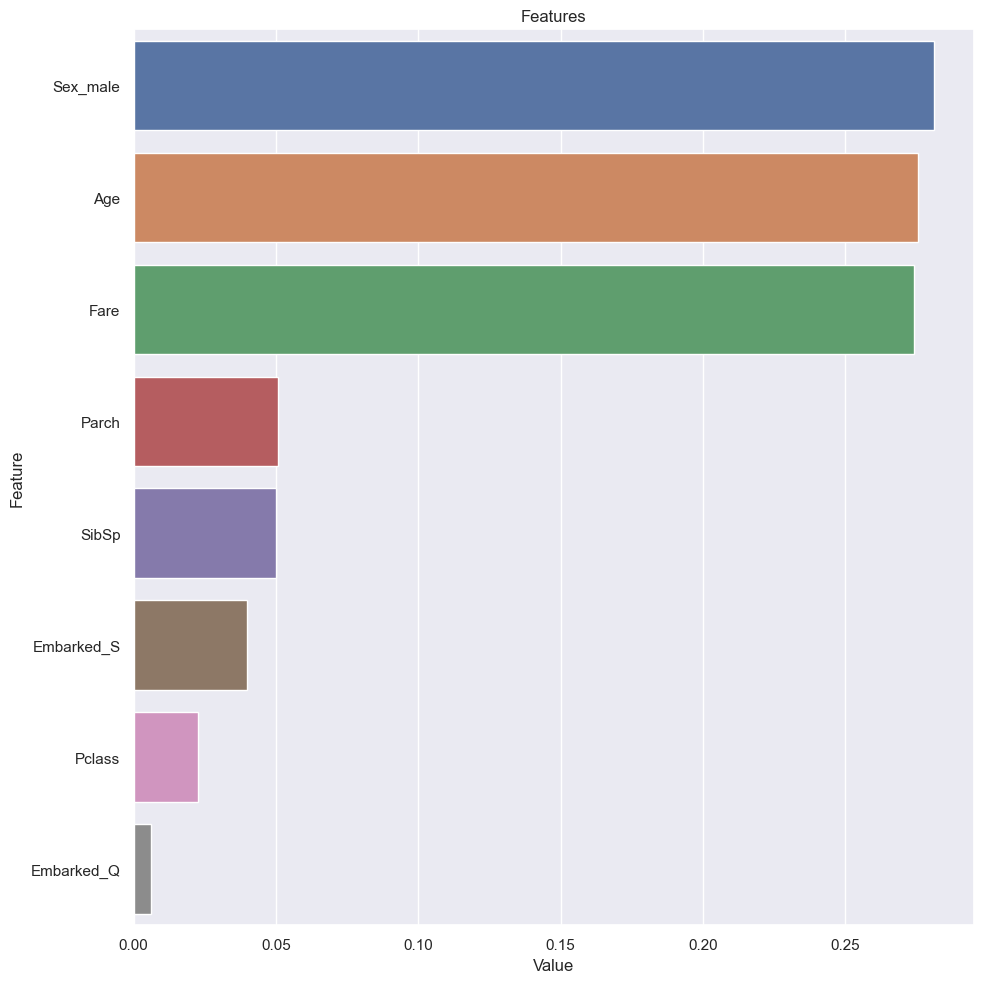

In [65]:
plot_importance(rf_model, X_train)

### Yukarıda hangi değişkenin ne kadar önemli olduğu görülmektedir. En tepelerde ise bizim feature engineering ile oluşturduğumuz değişkenlerin (veya oluşturduğumuz değişkenlerden birkaçının) olması yaptığımız işin değerini göstermektedir.